## Get the cleaned dataset and selected features

In [2]:
import os
from pathlib import Path
import pandas as pd

# Load data
path = Path(os.getcwd() + "/..").resolve()
dataset_path = path/'Datasets/Tabular/FOOD-DATA-GROUP.csv'
df = pd.read_csv(dataset_path)

df = df.drop("food", axis=1)
features = df.drop("Caloric Value", axis=1).columns.tolist()
target = "Caloric Value"

# Data transformation
from sklearn.preprocessing import PowerTransformer

# Initialize the PowerTransformer
pt = PowerTransformer(method='yeo-johnson', standardize=True)

# Transform the data
df_transformed = pt.fit_transform(df)

# Convert back to DataFrame
df = pd.DataFrame(df_transformed, columns=df.columns)

# Remove outliers
from scipy.stats import zscore
import numpy as np

X = df[features]

# Calculate Z-scores for the features
z_scores = np.abs(zscore(X))

# Define a threshold for Z-scores
threshold = 3

# Find rows where all features have Z-scores greater than the threshold
outliers = (z_scores > threshold).any(axis=1)

# Remove rows where any feature's Z-score exceeds the threshold
X_clean_zscore = X[~outliers]

# Get the indices of the rows that are not outliers
valid_indices = X[~outliers].index

df = df.loc[valid_indices]

# Selected features
df['Protein+Carbohydrates+Fat'] = df['Protein']+df['Carbohydrates']+df['Fat']
df['Total Fats'] = df['Polyunsaturated Fats'] + df['Saturated Fats'] + df['Monounsaturated Fats']

new_features = ['Protein+Carbohydrates+Fat', 'Total Fats']

selected_features = ['Nutrition Density', 'Zinc', 'Vitamin B3', 'Calcium', 'Sodium', 'Dietary Fiber', 'Vitamin C', 'Selenium', 'Protein+Carbohydrates+Fat', 'Total Fats']

X = df[selected_features]
y = df[target]


## Initialise models


In [4]:
from sklearn.model_selection import GridSearchCV

### Linear Regression

In [6]:
from sklearn.linear_model import LinearRegression

lin_reg_model = LinearRegression()

### Decision Tree Regressor

In [8]:
from sklearn.tree import DecisionTreeRegressor

dec_tree_param_grid = [{
    'max_depth': [2, 4, 7, 10],
    'min_samples_split': [2, 4, 7, 10],
    'min_samples_leaf': [2, 4, 7, 10]
    }]
dec_tree_grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), dec_tree_param_grid, cv=5, scoring='r2')
dec_tree_grid_search.fit(X, y)
dec_tree_grid_search.best_estimator_

DecisionTreeRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                      random_state=42)

In [9]:
# Initalize DecisionTreeRegressor with hyperparameters based on the best estimator from GridSearchCV
dec_tree_model = DecisionTreeRegressor(max_depth=10, min_samples_leaf=7, random_state=42)

### Random Forest Regressor

In [11]:
from sklearn.ensemble import RandomForestRegressor

forest_reg_param_grid = [{
    'n_estimators': [3, 10, 30],
    'min_samples_split': [2, 4, 7, 10],
    'min_samples_leaf': [2, 4, 7, 10]
    }]
forest_reg_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), forest_reg_param_grid, cv=5, scoring='r2')
forest_reg_grid_search.fit(X, y)
forest_reg_grid_search.best_estimator_

RandomForestRegressor(min_samples_leaf=2, n_estimators=30, random_state=42)

In [12]:
# Initalize RandomForestRegressor with hyperparameters based on the best estimator from GridSearchCV
forest_reg_model = RandomForestRegressor(n_estimators=30, min_samples_leaf=2, min_samples_split=7, random_state=42)

## Calculate R² score for each model for various train-test split

In [14]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import numpy as np

# Test size from 0.01 to 0.99 inclusive
test_sizes = np.arange(0.01, 1.00, 0.01)
test_samples = []
lin_reg_r2_scores = []
dec_tree_r2_scores = []
forest_reg_r2_scores = []

for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    test_samples.append(X_test.shape[0])

    # Linear Regression
    lin_reg_model.fit(X_train, y_train)
    lin_reg_pred = lin_reg_model.predict(X_test)
    # Calculate R² score and add to list
    lin_reg_r2_scores.append(r2_score(y_test, lin_reg_pred))

    # Decision Tree Regressor
    dec_tree_model.fit(X_train, y_train)
    dec_tree_pred = dec_tree_model.predict(X_test)
    # Calculate R² score and add to list
    dec_tree_r2_scores.append(r2_score(y_test, dec_tree_pred))

    # Random Forest Regressor
    forest_reg_model.fit(X_train, y_train)
    forest_reg_pred = forest_reg_model.predict(X_test)
    # Calculate R² score and add to list
    forest_reg_r2_scores.append(r2_score(y_test, forest_reg_pred))

## Plot R² scores against number of test samples

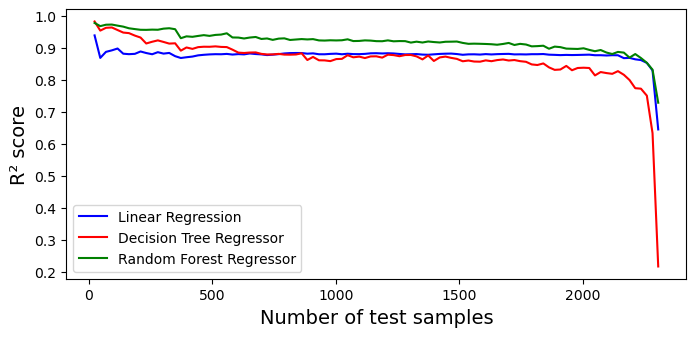

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3.5))

plt.plot(test_samples, lin_reg_r2_scores, "b", label="Linear Regression")
plt.plot(test_samples, dec_tree_r2_scores, "r", label="Decision Tree Regressor")
plt.plot(test_samples, forest_reg_r2_scores, "g", label="Random Forest Regressor")

plt.xlabel("Number of test samples", fontsize=14)
plt.ylabel("R² score", fontsize=14)

plt.legend()

plt.show()